In [10]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams.update({'font.size':10})

mu = 1e-3*0.697

FF_INNER = 10
FF_OUTER = 11
FF_ENDS = 12

mesh_names = ['artery', 'artery2', 'vein', 'vein2']
centers = [[0,0], [0.584, -0.23], [0,0], [0.707, -0.26]]
inner_radius = 1

In [96]:

radiuses = [1]

meshes = []
sols = []

radius = 1

for i, mesh_name in enumerate(mesh_names):
    for inner_radius in radiuses:
        mesh = Mesh()
        h5 = HDF5File(mesh.mpi_comm(), '../data/' + mesh_name + '.h5', 'r')
        h5.read(mesh, '/mesh', False)
        ff = MeshFunction('size_t', mesh, 1)
        h5.read(ff, '/facet_tags')
        File('ff.pvd')<<ff

        # Center at (0,0)
        c = mesh.coordinates()
        c -= centers[i]

        # Get coordinates on inner boundary
        V = FunctionSpace(mesh, 'CG', 1)
        d2v = dof_to_vertex_map(V)
        bc = DirichletBC(V, Constant(0), ff, FF_INNER)
        inner_coords = []
        for dof in bc.get_boundary_values():
            vertex = Vertex(mesh, d2v[dof])
            inner_coords.append([vertex.x(i) for i in range(2)])
        min_inner_radius_tilde = np.min(np.linalg.norm(inner_coords, axis=1))


        scaling = inner_radius/min_inner_radius_tilde

        mesh.coordinates()[:,0]*=scaling
        mesh.coordinates()[:,1]*=scaling

        sol, Q, A = solve_for_vp(mesh)

        R = mu/Q
        vf = mu/A
        #print(f'R={R:1.2e}, vf={vf:1.2e}, ratio={R/vf:1.2e}')
        print(f'{Q/A:1.3f}')

        sol.rename('u-cs', '0')
        File('u-cs.pvd')<<sol
        sols.append(sol)


0.034
0.138
0.036
0.087


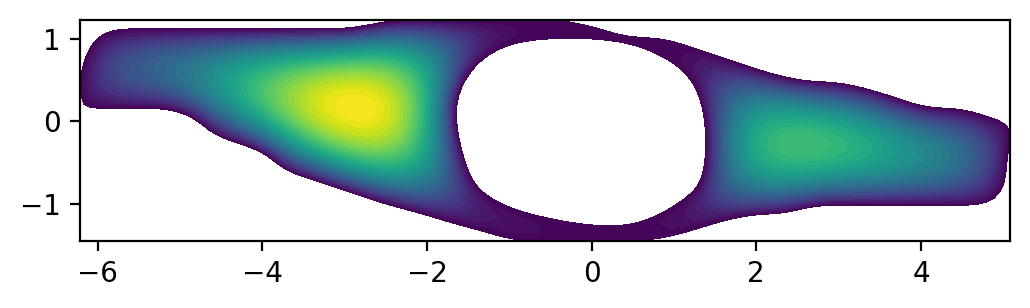

In [90]:
plot(sols[1])
plt.savefig('arterial1.png')

In [40]:

np.min(np.linalg.norm(inner_coords, axis=1))

0.5120169903404534

In [2]:
def solve_for_vp(mesh):
    V = FunctionSpace(mesh, 'CG', 1)
    u = TrialFunction(V)
    v = TestFunction(V)

    a = inner(grad(u), grad(v))*dx
    L = Constant(1)*v*dx

    bc = DirichletBC(V, Constant(0), 'on_boundary')
    sol = Function(V)
    solve(a==L, sol, bc)
    
    Q = assemble(sol*dx)
    A = assemble(interpolate(Constant(1),sol.function_space())*dx)
    
    return sol, Q, A

0.02

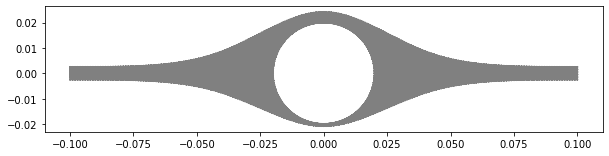

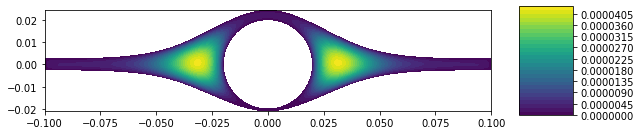

In [45]:
plt.figure(figsize=(10,20))
plt.colorbar(plot(sol), shrink=0.1, aspect=20*0.1)